# Lab 5: Building the Evaluation Framework
## Learning Objectives
By the end of this lab, you will:
- Create a Golden Dataset for retrieval evaluation
- Implement Hit Rate@K, MRR, Precision@K, and Recall@K metrics from scratch
- Visualize the Precision-Recall trade-off
- Understand LLM-as-Judge evaluation with DeepEval concepts
## Setup

In [1]:
!uv pip install numpy matplotlib -q


## Part 1: The Golden Dataset

A **golden dataset** (also called a ground-truth dataset) is a hand-curated collection of query-document relevance pairs. It serves as the **single source of truth** for evaluating your retrieval pipeline.

Why golden datasets are critical:
- **Reproducibility**: Without fixed evaluation data, you cannot compare experiments meaningfully.
- **Regression detection**: When you change chunking strategies, embedding models, or retrieval parameters, the golden dataset tells you if quality improved or degraded.
- **Human alignment**: Domain experts label what "relevant" means, anchoring your metrics to real-world expectations.

Each entry maps a **query** to the set of **document IDs** that a human has judged as relevant.

In [2]:
# Golden Dataset: hand-curated query -> relevant document pairs
golden_dataset = [
    {
        "query_id": "q1",
        "query": "What is Retrieval-Augmented Generation?",
        "relevant_doc_ids": {"doc_rag_intro_0", "doc_rag_overview_1"},
    },
    {
        "query_id": "q2",
        "query": "Explain the transformer self-attention mechanism",
        "relevant_doc_ids": {"doc_attention_0", "doc_attention_1", "doc_transformer_arch_0"},
    },
    {
        "query_id": "q3",
        "query": "Compare BM25 with semantic search",
        "relevant_doc_ids": {"doc_hybrid_search_0", "doc_bm25_explained_0"},
    },
    {
        "query_id": "q4",
        "query": "How does HNSW indexing work?",
        "relevant_doc_ids": {"doc_hnsw_algorithm_0", "doc_hnsw_params_0"},
    },
    {
        "query_id": "q5",
        "query": "What chunking strategy is best for research papers?",
        "relevant_doc_ids": {"doc_chunking_strategies_0", "doc_recursive_chunking_0"},
    },
]

print(f"Golden dataset: {len(golden_dataset)} queries")
for item in golden_dataset:
    print(f"  {item['query_id']}: '{item['query'][:50]}...' -> {len(item['relevant_doc_ids'])} relevant docs")


Golden dataset: 5 queries
  q1: 'What is Retrieval-Augmented Generation?...' -> 2 relevant docs
  q2: 'Explain the transformer self-attention mechanism...' -> 3 relevant docs
  q3: 'Compare BM25 with semantic search...' -> 2 relevant docs
  q4: 'How does HNSW indexing work?...' -> 2 relevant docs
  q5: 'What chunking strategy is best for research papers...' -> 2 relevant docs


## Part 2: Simulated Retrieval Results

To evaluate our metrics, we need retrieval results to score against the golden dataset. Below we simulate what a retrieval system might return: an **ordered list** of document IDs for each query, ranked from most to least relevant (as the system sees it).

Some retrievals are good (relevant docs ranked first), some are poor (relevant docs buried or missing).

In [3]:
# Simulated retrieval results (what our system actually returned)
# Each query -> ordered list of doc IDs retrieved (best first)
simulated_retrievals = {
    "q1": ["doc_rag_intro_0", "doc_other_1", "doc_rag_overview_1", "doc_noise_2", "doc_noise_3"],
    "q2": ["doc_unrelated_0", "doc_attention_1", "doc_noise_1", "doc_attention_0", "doc_noise_2"],
    "q3": ["doc_hybrid_search_0", "doc_bm25_explained_0", "doc_noise_1", "doc_noise_2", "doc_noise_3"],
    "q4": ["doc_noise_0", "doc_noise_1", "doc_hnsw_algorithm_0", "doc_noise_2", "doc_hnsw_params_0"],
    "q5": ["doc_chunking_strategies_0", "doc_noise_0", "doc_noise_1", "doc_noise_2", "doc_noise_3"],
}

print("Simulated retrieval results (top 5 per query):")
for qid, docs in simulated_retrievals.items():
    query = next(g for g in golden_dataset if g['query_id'] == qid)
    relevant = query['relevant_doc_ids']
    hits = [("*" if d in relevant else " ") for d in docs]
    print(f"  {qid}: {' | '.join(f'{h}{d[:20]}' for h, d in zip(hits, docs))}")
print("\n  (* = relevant document)")


Simulated retrieval results (top 5 per query):
  q1: *doc_rag_intro_0 |  doc_other_1 | *doc_rag_overview_1 |  doc_noise_2 |  doc_noise_3
  q2:  doc_unrelated_0 | *doc_attention_1 |  doc_noise_1 | *doc_attention_0 |  doc_noise_2
  q3: *doc_hybrid_search_0 | *doc_bm25_explained_0 |  doc_noise_1 |  doc_noise_2 |  doc_noise_3
  q4:  doc_noise_0 |  doc_noise_1 | *doc_hnsw_algorithm_0 |  doc_noise_2 | *doc_hnsw_params_0
  q5: *doc_chunking_strateg |  doc_noise_0 |  doc_noise_1 |  doc_noise_2 |  doc_noise_3

  (* = relevant document)


## Part 3: Implementing Retrieval Metrics

We will implement four core retrieval metrics from scratch:

| Metric | What it measures | Range |
|--------|-----------------|-------|
| **Hit Rate@K** | Did we find *at least one* relevant doc in top K? | 0-1 |
| **MRR** (Mean Reciprocal Rank) | How early does the first relevant doc appear? | 0-1 |
| **Precision@K** | What fraction of the top K results are relevant? | 0-1 |
| **Recall@K** | What fraction of *all* relevant docs did we find in top K? | 0-1 |

In [4]:
from typing import List, Set

def hit_rate_at_k(retrieved: List[List[str]], relevant: List[Set[str]], k: int) -> float:
    """Fraction of queries where at least one relevant doc is in top K."""
    hits = 0
    for ret, rel in zip(retrieved, relevant):
        if any(doc_id in rel for doc_id in ret[:k]):
            hits += 1
    return hits / len(retrieved)

def mean_reciprocal_rank(retrieved: List[List[str]], relevant: List[Set[str]]) -> float:
    """Average of 1/rank of first relevant document."""
    rr_sum = 0.0
    for ret, rel in zip(retrieved, relevant):
        for rank, doc_id in enumerate(ret, 1):
            if doc_id in rel:
                rr_sum += 1.0 / rank
                break
    return rr_sum / len(retrieved)

def precision_at_k(retrieved: List[List[str]], relevant: List[Set[str]], k: int) -> float:
    """Average fraction of relevant docs in top K."""
    precisions = []
    for ret, rel in zip(retrieved, relevant):
        top_k = ret[:k]
        relevant_in_k = sum(1 for d in top_k if d in rel)
        precisions.append(relevant_in_k / k)
    return sum(precisions) / len(precisions)

def recall_at_k(retrieved: List[List[str]], relevant: List[Set[str]], k: int) -> float:
    """Average fraction of all relevant docs found in top K."""
    recalls = []
    for ret, rel in zip(retrieved, relevant):
        if not rel:
            recalls.append(0.0)
            continue
        top_k = ret[:k]
        found = sum(1 for d in top_k if d in rel)
        recalls.append(found / len(rel))
    return sum(recalls) / len(recalls)

# Prepare data
all_retrieved = [simulated_retrievals[g['query_id']] for g in golden_dataset]
all_relevant = [g['relevant_doc_ids'] for g in golden_dataset]

# Calculate metrics at different K values
print("Retrieval Metrics:")
print(f"{'K':>3} {'Hit Rate':>10} {'MRR':>10} {'Precision':>10} {'Recall':>10}")
print("-" * 45)
for k in [1, 3, 5]:
    hr = hit_rate_at_k(all_retrieved, all_relevant, k)
    mrr = mean_reciprocal_rank(all_retrieved, all_relevant)
    prec = precision_at_k(all_retrieved, all_relevant, k)
    rec = recall_at_k(all_retrieved, all_relevant, k)
    print(f"{k:>3} {hr:>10.3f} {mrr:>10.3f} {prec:>10.3f} {rec:>10.3f}")


Retrieval Metrics:
  K   Hit Rate        MRR  Precision     Recall
---------------------------------------------
  1      0.600      0.767      0.600      0.300
  3      1.000      0.767      0.467      0.667
  5      1.000      0.767      0.360      0.833


## Part 4: Precision-Recall Visualization

The **Precision-Recall trade-off** is fundamental: as you increase K (retrieve more documents), recall goes up (you find more relevant docs) but precision tends to go down (you also retrieve more noise). The sweet spot depends on your application.

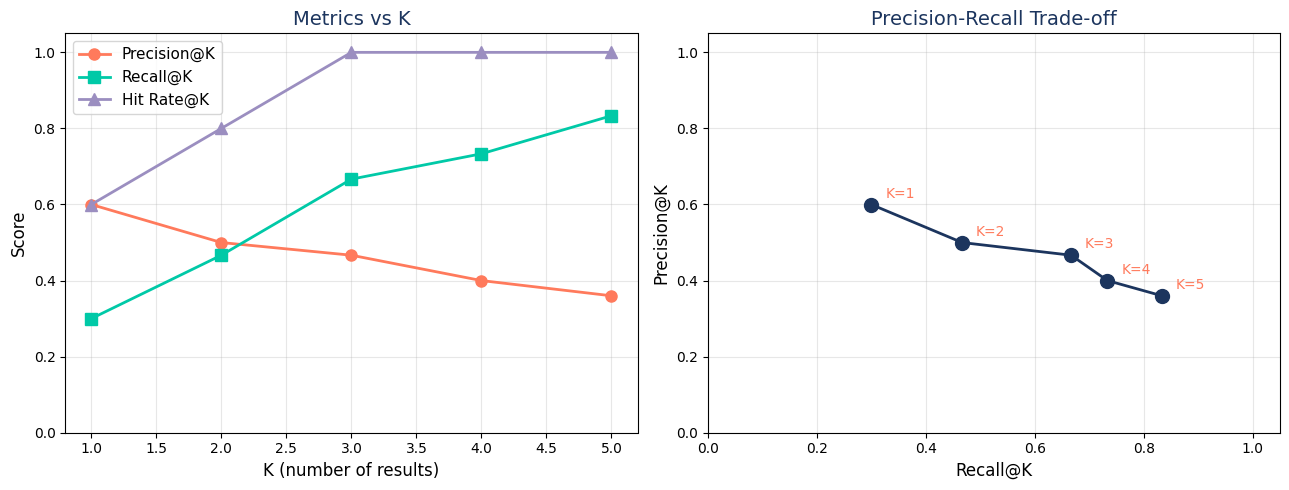

In [5]:
import matplotlib.pyplot as plt
import numpy as np

k_values = list(range(1, 6))
precisions = [precision_at_k(all_retrieved, all_relevant, k) for k in k_values]
recalls = [recall_at_k(all_retrieved, all_relevant, k) for k in k_values]
hit_rates = [hit_rate_at_k(all_retrieved, all_relevant, k) for k in k_values]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Precision & Recall vs K
ax1.plot(k_values, precisions, 'o-', color='#FF7A5C', linewidth=2, markersize=8, label='Precision@K')
ax1.plot(k_values, recalls, 's-', color='#00C9A7', linewidth=2, markersize=8, label='Recall@K')
ax1.plot(k_values, hit_rates, '^-', color='#9B8EC0', linewidth=2, markersize=8, label='Hit Rate@K')
ax1.set_xlabel('K (number of results)', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Metrics vs K', fontsize=14, color='#1C355E')
ax1.legend(fontsize=11)
ax1.set_ylim(0, 1.05)
ax1.grid(True, alpha=0.3)

# Precision vs Recall curve
ax2.plot(recalls, precisions, 'o-', color='#1C355E', linewidth=2, markersize=10)
for i, k in enumerate(k_values):
    ax2.annotate(f'K={k}', (recalls[i], precisions[i]), textcoords="offset points",
                xytext=(10, 5), fontsize=10, color='#FF7A5C')
ax2.set_xlabel('Recall@K', fontsize=12)
ax2.set_ylabel('Precision@K', fontsize=12)
ax2.set_title('Precision-Recall Trade-off', fontsize=14, color='#1C355E')
ax2.set_xlim(0, 1.05)
ax2.set_ylim(0, 1.05)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Exercise 4.1: Per-Query Analysis

Aggregate metrics hide per-query performance. Complete the function below to analyze each query individually and identify weak spots in your retrieval pipeline.

In [6]:
def per_query_analysis(golden_dataset, simulated_retrievals, k=3):
    """Analyze each query individually to find weak spots."""
    results = []
    for item in golden_dataset:
        qid = item['query_id']
        retrieved = simulated_retrievals[qid][:k]
        relevant = item['relevant_doc_ids']
        
        # TODO: Calculate hit (True/False) - is any relevant doc in top K?
        hit = any(doc_id in relevant for doc_id in retrieved)
        
        
        # TODO: Calculate precision for this query
        prec = 0.0  # relevant found in top k / k
        if retrieved:
            prec = sum(1 for doc_id in retrieved if doc_id in relevant) / len(retrieved)
        
        # TODO: Calculate recall for this query
        rec = 0.0  # relevant found in top k / total relevant
        if relevant:
            rec = sum(1 for doc_id in retrieved if doc_id in relevant) / len(relevant)
        
        # TODO: Find the rank of first relevant doc (0 if not found in top K)
        first_relevant_rank = 0
        for rank, doc_id in enumerate(retrieved, 1):
            if doc_id in relevant:
                first_relevant_rank = rank
                break
        
        results.append({
            "query_id": qid,
            "query": item['query'][:40],
            "hit": hit,
            "precision": prec,
            "recall": rec,
            "first_rank": first_relevant_rank,
        })
    
    return results

analysis = per_query_analysis(golden_dataset, simulated_retrievals, k=3)
from tests import checks
checks.check_lab_5_4(analysis)

print(f"{'Query':<45} {'Hit':>5} {'P@3':>6} {'R@3':>6} {'1st Rank':>9}")
print("-" * 75)
for r in analysis:
    hit_str = "Y" if r['hit'] else "N"
    print(f"{r['query']:<45} {hit_str:>5} {r['precision']:>6.2f} {r['recall']:>6.2f} {r['first_rank']:>9}")

# Identify weakest query
worst = min(analysis, key=lambda x: x['recall'] if x['recall'] is not None else 0)
print(f"\nWeakest query: {worst['query_id']} - '{worst['query']}' (Recall: {worst['recall']})")
print("Per-query analysis working!")


✅ Per-query analysis working!
Query                                           Hit    P@3    R@3  1st Rank
---------------------------------------------------------------------------
What is Retrieval-Augmented Generation?           Y   0.67   1.00         1
Explain the transformer self-attention m          Y   0.33   0.33         2
Compare BM25 with semantic search                 Y   0.67   1.00         1
How does HNSW indexing work?                      Y   0.33   0.50         3
What chunking strategy is best for resea          Y   0.33   0.50         1

Weakest query: q2 - 'Explain the transformer self-attention m' (Recall: 0.3333333333333333)
Per-query analysis working!


## Part 5: Generation Evaluation Concepts

Retrieval metrics tell you whether you found the right documents. But did the LLM **use** those documents correctly to generate an answer?

**LLM-as-Judge** is a paradigm where a powerful LLM (e.g., GPT-4) evaluates the quality of another model's output. Key dimensions:

- **Faithfulness**: Is the answer grounded in the retrieved context, or does it hallucinate?
- **Answer Relevance**: Does the answer actually address the user's question?
- **Contextual Precision**: Are the most relevant chunks ranked first in the context window?

Below we demonstrate simplified heuristic versions of these metrics. In production, you would use frameworks like **DeepEval** that leverage GPT-4 as a judge for more nuanced evaluation.

In [7]:
# Demonstrate the concept of LLM-as-Judge evaluation
# In production: use DeepEval framework

def evaluate_faithfulness(answer, context):
    """
    Check if the answer is faithful to the context (no hallucination).
    In production: DeepEval's FaithfulnessMetric with GPT-4 as judge.
    """
    # Simple heuristic: check if key phrases from answer appear in context
    answer_words = set(answer.lower().split())
    context_words = set(context.lower().split())
    overlap = len(answer_words & context_words)
    score = overlap / max(len(answer_words), 1)
    return min(score, 1.0)

def evaluate_relevance(answer, query):
    """
    Check if the answer is relevant to the query.
    In production: DeepEval's AnswerRelevanceMetric.
    """
    query_words = set(query.lower().split())
    answer_words = set(answer.lower().split())
    overlap = len(query_words & answer_words)
    return min(overlap / max(len(query_words), 1), 1.0)

# Test cases
test_cases = [
    {
        "query": "What is RAG?",
        "context": "RAG combines retrieval with generation to ground LLM responses in external knowledge, reducing hallucinations.",
        "answer": "RAG (Retrieval-Augmented Generation) combines retrieval with generation to ground responses in external knowledge [1].",
        "expected": "high faithfulness"
    },
    {
        "query": "What is RAG?",
        "context": "RAG combines retrieval with generation.",
        "answer": "RAG was invented by Facebook AI Research in 2020 and uses FAISS for vector search.",
        "expected": "low faithfulness (hallucination)"
    },
]

print("Generation Evaluation (Simulated):")
print("-" * 70)
for tc in test_cases:
    faith = evaluate_faithfulness(tc['answer'], tc['context'])
    relev = evaluate_relevance(tc['answer'], tc['query'])
    print(f"Query: {tc['query']}")
    print(f"Answer: {tc['answer'][:80]}...")
    print(f"Faithfulness: {faith:.2f} | Relevance: {relev:.2f} | Expected: {tc['expected']}")
    print()


Generation Evaluation (Simulated):
----------------------------------------------------------------------
Query: What is RAG?
Answer: RAG (Retrieval-Augmented Generation) combines retrieval with generation to groun...
Faithfulness: 0.71 | Relevance: 0.00 | Expected: high faithfulness

Query: What is RAG?
Answer: RAG was invented by Facebook AI Research in 2020 and uses FAISS for vector searc...
Faithfulness: 0.07 | Relevance: 0.00 | Expected: low faithfulness (hallucination)



### Production Evaluation with DeepEval

In production, you would use the **DeepEval** framework for automated evaluation:

```python
# pip install deepeval
from deepeval.test_case import LLMTestCase
from deepeval.metrics import FaithfulnessMetric, AnswerRelevanceMetric
from deepeval import assert_test

faithfulness = FaithfulnessMetric(threshold=0.7, model="gpt-4o")
relevance = AnswerRelevanceMetric(threshold=0.7, model="gpt-4o")

test_case = LLMTestCase(
    input="What is RAG?",
    actual_output="RAG combines retrieval with generation [1].",
    retrieval_context=["RAG combines retrieval with generation..."]
)

assert_test(test_case, [faithfulness, relevance])
```

**Key metrics:**
- **Faithfulness**: Is the answer derived purely from the context? (catches hallucinations)
- **Answer Relevance**: Does the answer address the question?
- **Contextual Precision**: Are relevant chunks ranked highly in the context?

> **Note:** DeepEval uses GPT-4 as a judge, which costs ~$0.01-0.05 per evaluation. Budget accordingly.

### Exercise 6.1: Build a Test Suite

Complete the `run_eval_suite` function to evaluate a batch of RAG responses using our simplified faithfulness and relevance metrics.

In [8]:
def run_eval_suite(rag_responses):
    """
    Run evaluation on a batch of RAG responses.
    
    Args:
        rag_responses: List of dicts with keys: query, answer, context, expected_answer (optional)
    """
    results = []
    
    for resp in rag_responses:
        # TODO: Calculate faithfulness score
        faith = evaluate_faithfulness(resp['answer'], resp['context'])
        
        # TODO: Calculate relevance score
        relev = evaluate_relevance(resp['answer'], resp['context'])
        
        # TODO: Determine pass/fail using threshold 0.5
        passed = faith >= 0.5 and relev >= 0.5
        
        results.append({
            "query": resp['query'][:40],
            "faithfulness": faith,
            "relevance": relev,
            "passed": passed,
        })
    
    return results

# Test data
test_responses = [
    {
        "query": "What is chunking?",
        "answer": "Chunking is splitting documents into smaller pieces for embedding and retrieval.",
        "context": "Chunking is the process of breaking documents into smaller, manageable pieces for embedding and storage in vector databases."
    },
    {
        "query": "How does HNSW work?",
        "answer": "HNSW builds a multi-layer graph for approximate nearest neighbor search.",
        "context": "HNSW (Hierarchical Navigable Small World) is an algorithm that builds a multi-layered graph structure for fast approximate nearest neighbor search."
    },
]

suite_results = run_eval_suite(test_responses)
from tests import checks
checks.check_lab_5_6(suite_results)

print(f"{'Query':<42} {'Faith':>7} {'Relev':>7} {'Pass':>6}")
print("-" * 65)
for r in suite_results:
    status = "PASS" if r['passed'] else "FAIL"
    print(f"{r['query']:<42} {r['faithfulness']:>7.2f} {r['relevance']:>7.2f} {status:>6}")

pass_rate = sum(1 for r in suite_results if r['passed']) / len(suite_results)
print(f"\nPass rate: {pass_rate:.0%}")
print("Eval suite working!")


✅ Eval suite working!
Query                                        Faith   Relev   Pass
-----------------------------------------------------------------
What is chunking?                             0.73    0.44   FAIL
How does HNSW work?                           0.90    0.45   FAIL

Pass rate: 0%
Eval suite working!


## Reflection Questions
1. **Metric Choice**: A legal discovery system needs to find ALL relevant precedents. Which metric matters most: Precision@K or Recall@K? Why?
2. **Golden Dataset Size**: How many query-document pairs do you need for a reliable evaluation? What are the trade-offs of too few vs too many?
3. **LLM-as-Judge**: What are the risks of using GPT-4 to evaluate GPT-4's outputs? How would you mitigate this?

*Your answers here:*
1. Recall@K هو الأهم لأن بالأنظمة القانونية لازم تطلع كل السوابق وما تفوت أي دليل حتى لو زادت النتائج غير الدقيقة
2. تحتاج من 50 إلى 100 استعلام والعدد القليل يظلم النتائج والعدد الكبير مكلف ومرهق بالتحقق اليدوي من جودة الإجابات
3. لخطر هو انحياز النموذج لنفسه ولأسلوبه وحلها بإنك تستخدم نماذج مختلفة للتقييم أو تخلي التقييم يعتمد على معايير مرجعية صلبة

س